In [1]:
import jax
from jax import numpy as jnp
from jax.config import config; config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import sys; sys.path.insert(1, '..')

from algs.train import PG_Trainer, TracePlotter
from env.utils import ExampleMDPs
from env.gridworld import gridplot

### Example training with oracle access to the gradients

In [2]:
mdp = ExampleMDPs.gworld1()
trainer = PG_Trainer(mdp,policy_lr=2,beta=0.01,max_theta=1e3)
optimizers, trace = trainer.train(60)

100%|██████████| 60/60 [00:02<00:00, 22.52it/s]


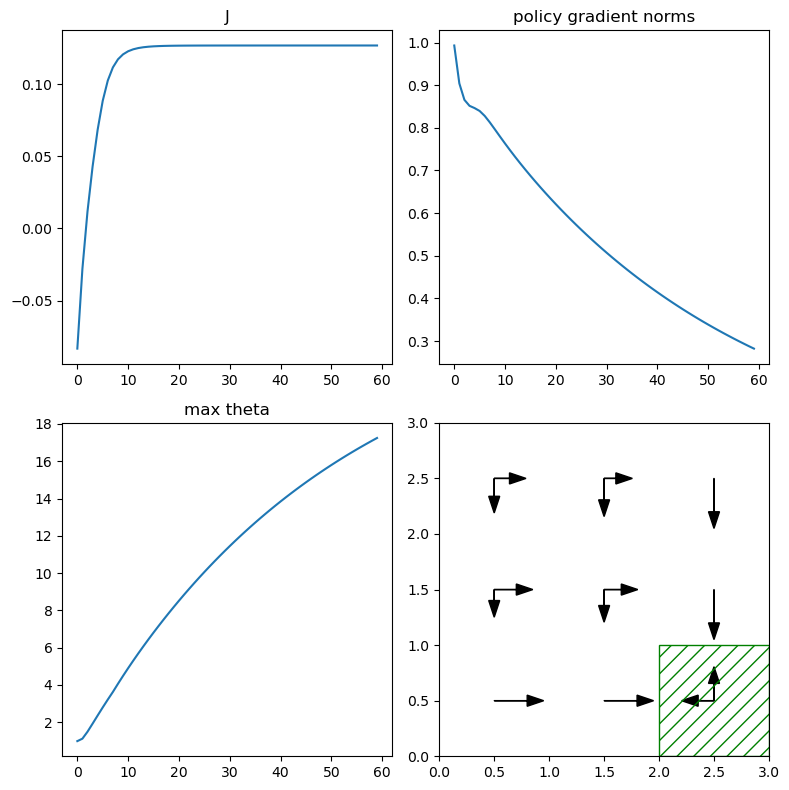

In [3]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
TracePlotter.plotScalar(ax[0,0],'J',trace)
TracePlotter.plotGradNorms(ax[0,1],'policy',trace)
tmaxs=jnp.array([jnp.max(e['params']['policy']) for e in trace])
ax[1,0].plot(tmaxs); ax[1,0].set_title('max theta')
gridplot(mdp,ax[1,1],stochastic_policy=trainer.pFun(optimizers['policy']),goals=mdp.goals)
fig.tight_layout()
plt.show()

### Training with Monte-Carlo gradient estimators

In [4]:
from env.sample import Sampler
from algs.pg import stochNaturalPG


mdp = ExampleMDPs.gworld1()
smp = Sampler(mdp,batchsize=300,horizon=150)
trainer = PG_Trainer(mdp,policy_lr=0.08,beta=1e-4,sampler=smp,gradients=stochNaturalPG,max_theta=1e3,key=jax.random.PRNGKey(1312))
optimizers, trace = trainer.train(60)

100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


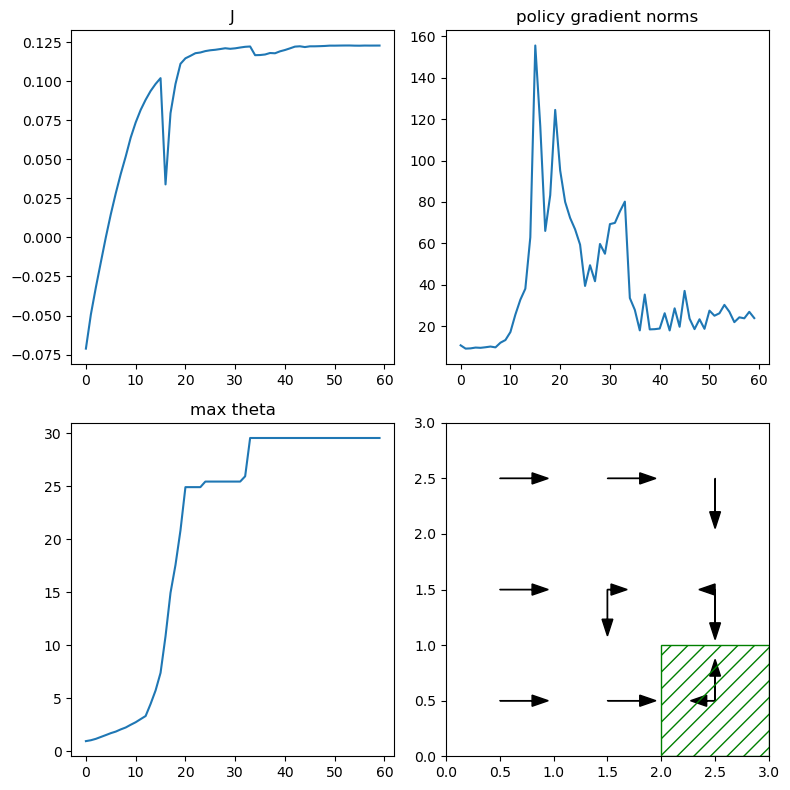

In [5]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
TracePlotter.plotScalar(ax[0,0],'J',trace)
TracePlotter.plotGradNorms(ax[0,1],'policy',trace)
tmaxs=jnp.array([jnp.max(e['params']['policy']) for e in trace])
ax[1,0].plot(tmaxs); ax[1,0].set_title('max theta')
gridplot(mdp,ax[1,1],stochastic_policy=trainer.pFun(optimizers['policy']),goals=mdp.goals)
fig.tight_layout()
plt.show()